In [1]:
from scipy import signal
import numpy as np
import pandas as pd

import bisect
import importlib

import warnings

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess


def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Monospace font for numbers in tables:

In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

## Load data

Hotspot data:

In [5]:
hotspots = pd.read_csv('../bed/hotspots.bed', names=['chrom', 'start', 'end'], sep='\t')
hotspots['pos'] = (hotspots.start + (hotspots.end - hotspots.start) / 2).round().astype(int)
hotspots['chrom'] = hotspots.chrom.str.replace('chr', '')
hotspots.rename(columns={'stop': 'end'}, inplace=True)
hotspots.head()

,chrom,start,end,pos
0,1,6892116,6896116,6894116
1,1,8803005,8807005,8805005
2,1,9684030,9690030,9687030
3,1,10395061,10399061,10397061
4,1,10500751,10506751,10503751


Composition and substitution data:

In [6]:
chromosomes = ['1', '1A', '2', '3', '4', '4A', '5', '6', '7', 
               '8', '9', '10', '11', '12', '13', '14', '15']
tmpl = '/Users/kmt/Dropbox/Shared/jonas_kasper/skew/chr{}.skew.txt'
lst = list()
for chrom in chromosomes:
    df = pd.read_csv(tmpl.format(chrom), sep=' ')
    df['chrom'] = chrom
    lst.append(df)
skew_data = pd.concat(lst)
skew_data['end'] = skew_data.start + 1000
skew_data.head()

,start,nA,nC,nG,nT,nA2C,nA2G,nA2T,nC2A,nC2G,nC2T,nG2A,nG2C,nG2T,nT2A,nT2C,nT2G,chrom,end
0,0,336,166,173,252,2,5,1,4,4,5,6,3,2,5,12,6,1,1000
1,1000,235,164,183,217,3,7,4,2,3,2,2,0,0,2,7,7,1,2000
2,2000,81,71,77,77,1,3,0,2,5,3,5,2,0,2,5,1,1,3000
3,3000,193,204,262,260,1,8,2,3,3,5,13,3,6,4,14,7,1,4000
4,4000,161,188,164,167,4,7,4,2,2,5,4,2,0,3,2,5,1,5000


Add additional stats to skew data set:

In [7]:
# composition skews:
skew_data['skew_GC'] = (skew_data.nG-skew_data.nC)/(skew_data.nG+skew_data.nC)
skew_data['skew_TA'] = (skew_data.nT-skew_data.nA)/(skew_data.nT+skew_data.nA)
skew_data['s'] = skew_data.skew_GC + skew_data.skew_TA #(skew_data.skew_GC - skew_data.skew_GC.shift()) + (skew_data.skew_TA - skew_data.skew_TA).shift()
skew_data['s_diff'] = skew_data.s - skew_data.s.shift()

# equilibrium composition skews:
GCflux = (skew_data.nA2C + skew_data.nT2C + skew_data.nA2G + skew_data.nT2G) / \
                (skew_data.nC2A + skew_data.nC2T + skew_data.nG2A + skew_data.nT2C)
skew_data['GCstar'] = GCflux/(1 + GCflux)

# substitution skews:
skew_TCAG = (skew_data.nT2C-skew_data.nA2G)/(skew_data.nT2C+skew_data.nA2G)

# equilibrium substution skews:



skew_data.reset_index(inplace=True)
skew_data.head()

,index,start,nA,nC,nG,nT,nA2C,nA2G,nA2T,nC2A,...,nT2A,nT2C,nT2G,chrom,end,skew_GC,skew_TA,s,s_diff,GCstar
0,0,0,336,166,173,252,2,5,1,4,...,5,12,6,1,1000,0.020649,-0.142857,-0.122208,NaN,0.480769
1,1,1000,235,164,183,217,3,7,4,2,...,2,7,7,1,2000,0.054755,-0.039823,0.014932,0.137140,0.648649
2,2,2000,81,71,77,77,1,3,0,2,...,2,5,1,1,3000,0.040541,-0.025316,0.015224,0.000292,0.400000
3,3,3000,193,204,262,260,1,8,2,3,...,4,14,7,1,4000,0.124464,0.147903,0.272366,0.257142,0.461538
4,4,4000,161,188,164,167,4,7,4,2,...,3,2,5,1,5000,-0.068182,0.018293,-0.049889,-0.322256,0.580645


CG islands:

In [8]:
cgi = pd.read_csv('../bed/CGI-taeGut1.txt', sep='\t')
cgi['pos'] = (cgi.start + (cgi.end - cgi.start) / 2).round().astype(int)
cgi['chrom'] = cgi['chr'].str.replace('chr', '')
cgi.head()

,chr,start,end,length,CpGcount,GCcount,pctGC,obsExp,pos,chrom
0,chr1,21810,21940,131,9,83,0.633588,0.685465,21875,1
1,chr1,31020,31136,117,15,82,0.700855,1.054054,31078,1
2,chr1,32772,33056,285,23,202,0.708772,0.642584,32914,1
3,chr1,47794,48027,234,12,130,0.555556,0.668571,47910,1
4,chr1,108367,108549,183,9,93,0.508197,0.772514,108458,1


Length distribution of CGIs:

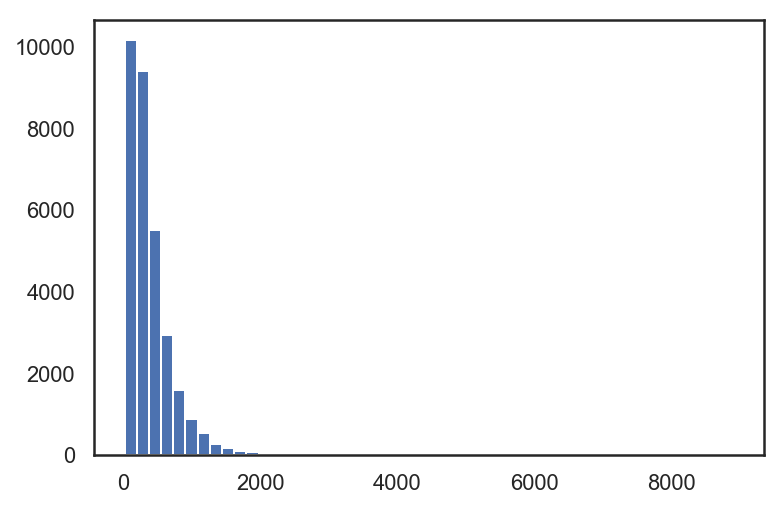

In [9]:
plt.hist(cgi.end-cgi.start, bins=50) ;

Transcription start sites:

In [10]:
tss_plus = pd.read_csv('../bed/tss_plus_1bp.bed', names=['chrom', 'start', 'end'], sep='\t')
tss_plus['pos'] = tss_plus.start
tss_plus['chrom'] = tss_plus.chrom.str.replace('chr', '')
tss_plus = tss_plus.loc[tss_plus.chrom.isin(chromosomes)]
tss_plus.head()

,chrom,start,end,pos
0,1,15046,15047,15046
1,1,642776,642777,642776
2,1,657663,657664,657663
3,1,718282,718283,718282
4,1,743173,743174,743173


In [11]:
tss_minus = pd.read_csv('../bed/tss_minus_1bp.bed', names=['chrom', 'start', 'end'], sep='\t').assign(pos=lambda df: df.start)
tss_minus['pos'] = tss_minus.start
tss_minus['chrom'] = tss_minus.chrom.str.replace('chr', '')
tss_minus = tss_minus.loc[tss_minus.chrom.isin(chromosomes)]
tss_minus.head()

,chrom,start,end,pos
0,1,229706,229707,229706
1,1,638630,638631,638630
2,1,797400,797401,797400
3,1,985470,985471,985470
4,1,1044107,1044108,1044107


In [12]:
tss = pd.concat([tss_plus, tss_minus])

Transcription end sites:

In [13]:
tes_plus = pd.read_csv('../bed/tes_plus_1bp.bed', names=['chrom', 'start', 'end'], sep='\t')
tes_plus['pos'] = tes_plus.start
tes_plus['chrom'] = tes_plus.chrom.str.replace('chr', '')
tes_plus = tes_plus.loc[tes_plus.chrom.isin(chromosomes)]

In [14]:
tes_minus = pd.read_csv('../bed/tes_minus_1bp.bed', names=['chrom', 'start', 'end'], sep='\t').assign(pos=lambda df: df.start)
tes_minus['pos'] = tes_minus.start
tes_minus['chrom'] = tes_minus.chrom.str.replace('chr', '')
tes_minus = tes_minus.loc[tes_minus.chrom.isin(chromosomes)]

In [15]:
tes = pd.concat([tes_plus, tes_minus])

Introns:

In [16]:
introns_plus = pd.read_csv('../bed/introns_plus.bed', names=['chrom', 'start', 'end'], sep='\t')
introns_plus['strand'] = 1
introns_minus = pd.read_csv('../bed/introns_minus.bed', names=['chrom', 'start', 'end'], sep='\t')
introns_minus['strand'] = -1
introns = pd.concat([introns_plus, introns_minus])
introns['pos'] = introns.start
introns['chrom'] = introns.chrom.str.replace('chr', '')
introns = introns.loc[introns.chrom.isin(chromosomes)]
introns = introns.sort_values(['chrom', 'start', 'end'])
introns.head()

,chrom,start,end,strand,pos
0,1,15070,16245,1,15070
1,1,16354,17230,1,16354
2,1,17346,24662,1,17346
3,1,24768,25776,1,24768
4,1,25957,28149,1,25957


In [17]:
# introns = pd.read_csv('../bed/introns.bed', names=['chrom', 'start', 'end'], sep='\t')
# introns['pos'] = introns.start
# introns['chrom'] = introns.chrom.str.replace('chr', '')
# introns = introns.loc[introns.chrom.isin(chromosomes)]
# introns.head()

In [18]:
len(hotspots), len(cgi), len(tss), len(tes)

(2856, 31628, 10258, 10258)

## Functions for remapping from centers of hotspots

In [19]:
import genominterv

importlib.reload(genominterv)

def get_remapped(query, annot):
    "Remaps all annot that does not overlap query"
    
    remapped = (genominterv.remap_interval_data(query, annot)
                      # exclude windows between ends of chromosomes and a hotspot:
                      .loc[lambda df: ~df.prox_start.isnull() & ~df.prox_end.isnull()]
                     )
    return remapped

def get_overlapping(query, annot):
    "Gets all query that spans an annot"
    
    query_grouped = query.groupby('chrom')
    annot_grouped = annot.groupby('chrom')

    df_list = list()
    for chrom in chromosomes:
        query_group = query_grouped.get_group(chrom)
        annot_group = annot_grouped.get_group(chrom)

        query_starts = query_group.start.tolist()
        query_ends = query_group.end.tolist()

        idx_list = list()    
        for pos in annot_group.pos:
            idx = bisect.bisect_right(query_starts, pos) - 1
            if pos < query_ends[idx]:
                idx_list.append(idx)
#             else:
#                 print(chrom, pos, query_starts[idx], query_ends[idx])
            idx_list = sorted(set(idx_list))
        df_list.append(query_group.iloc[idx_list])

    query_overlap = pd.concat(df_list).reset_index(drop=True)

    # Add the extra columns that are in `skew_data_dist` so concatention is possible and set `start` and `end` to 0:
    query_overlap['prox_start'] = query_overlap.start
    query_overlap['prox_end'] = query_overlap.end

    query_overlap['start_orig'] = query_overlap.start
    query_overlap['end_orig'] = query_overlap.end
    query_overlap['start'] = 0
    query_overlap['end'] = 0

    return query_overlap


def remap_data(query, annot):
    "Remap hotspot centers relative to other annotation intervals"
    
    annot_centers = annot.assign(start=annot.pos, end=annot.pos)
    
    query_dist = get_remapped(query, annot_centers)

    # must be single base annotation annotation
    # for this to work (hotspot centers)
    assert not (annot_centers.end - annot_centers.start).sum()    
    query_overlap = get_overlapping(query, annot_centers)

    merged = pd.concat([query_overlap, query_dist], sort=True)
    
    merged['pos'] = (merged.start + (merged.end - merged.start) / 2).astype(float).round().astype(int)
    merged['bin'] = merged.pos // 1000 * 1000

    return merged

## Substitution and composition skew around hotspots

In [20]:
skew_data_hotspot_centered = remap_data(skew_data, hotspots)
skew_data_hotspot_centered.head()

,GCstar,chrom,end,end_orig,index,nA,nA2C,nA2G,nA2T,nC,...,prox_end,prox_start,s,s_diff,skew_GC,skew_TA,start,start_orig,pos,bin
0,0.416667,1,0,6895000,6894,204,1,1,0,165,...,6895000,6894000,0.047592,0.154479,0.023669,0.023923,0,6894000,0,0
1,0.470588,1,0,8806000,8805,294,1,8,4,198,...,8806000,8805000,-0.008923,0.087692,0.031785,-0.040708,0,8805000,0,0
2,0.400000,1,0,9688000,9687,292,1,4,1,199,...,9688000,9687000,0.041430,0.100174,0.036320,0.005111,0,9687000,0,0
3,0.439024,1,0,10398000,10397,280,1,7,1,225,...,10398000,10397000,-0.053050,0.083726,-0.079137,0.026087,0,10397000,0,0
4,0.406250,1,0,10504000,10503,150,1,7,1,241,...,10504000,10503000,0.024484,NaN,-0.032120,0.056604,0,10503000,0,0


Distribution of distances of windows to hotspots:

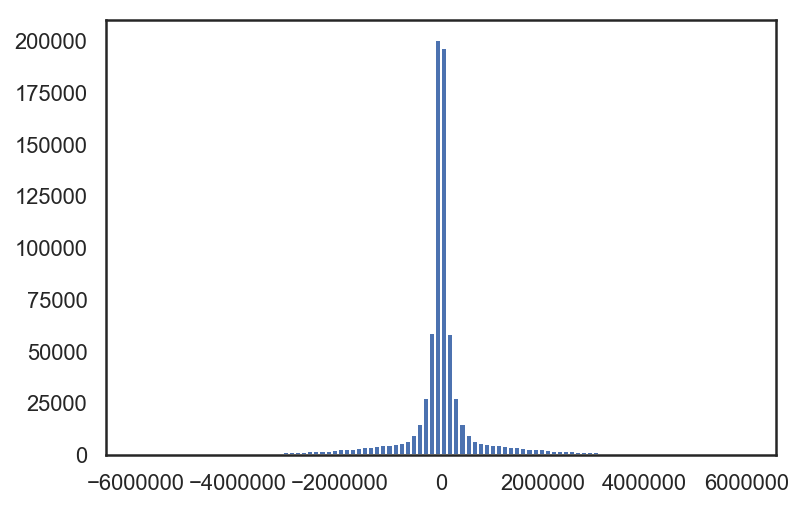

In [21]:
plt.hist(skew_data_hotspot_centered.start, bins=100) ;

Skew around hotspots:

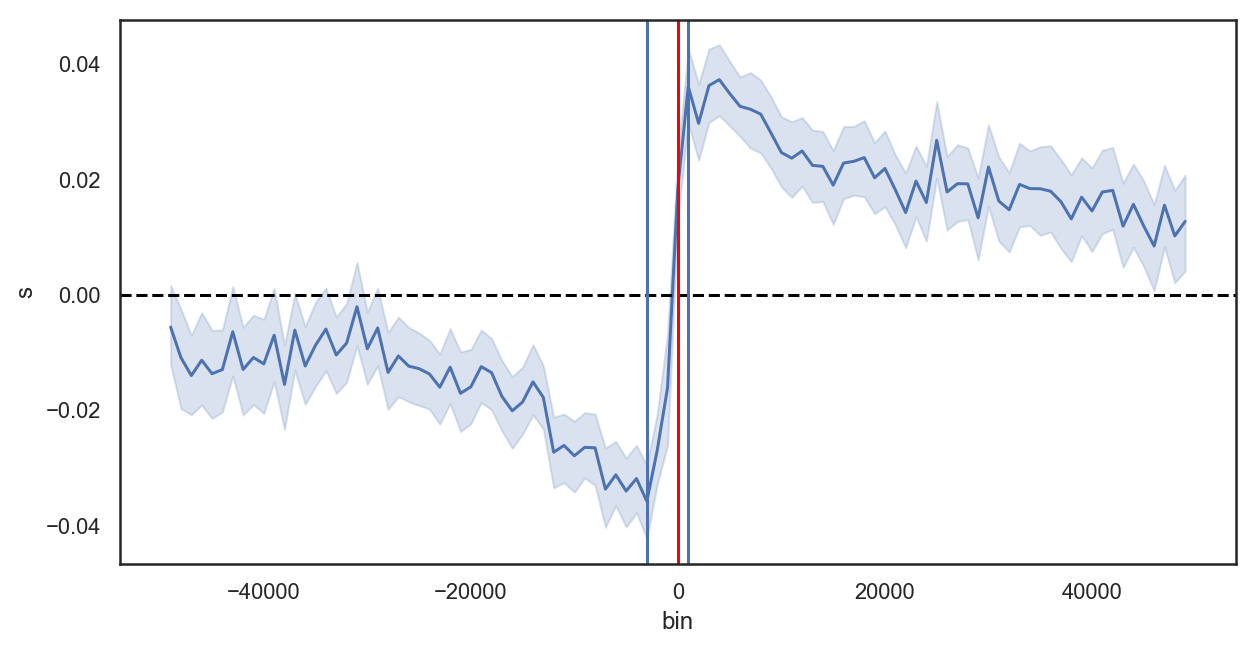

In [22]:
plot_df = skew_data_hotspot_centered.loc[skew_data_hotspot_centered.bin.abs() < 50000]

with warnings.catch_warnings(): # ignore FutureWarning
    warnings.simplefilter("ignore")

    plt.figure(figsize=(10, 5))
    sns.lineplot('bin', 's', data=plot_df, markers=True) ;
    plt.axhline(0, color='black', linestyle='dashed')
    plt.axvline(0, color='red')
    plt.axvline(1000)
    plt.axvline(-3000) ;

See what happens if I uniformly redistribute hotspot in a window around its original position:

//anaconda/envs/hotspots/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


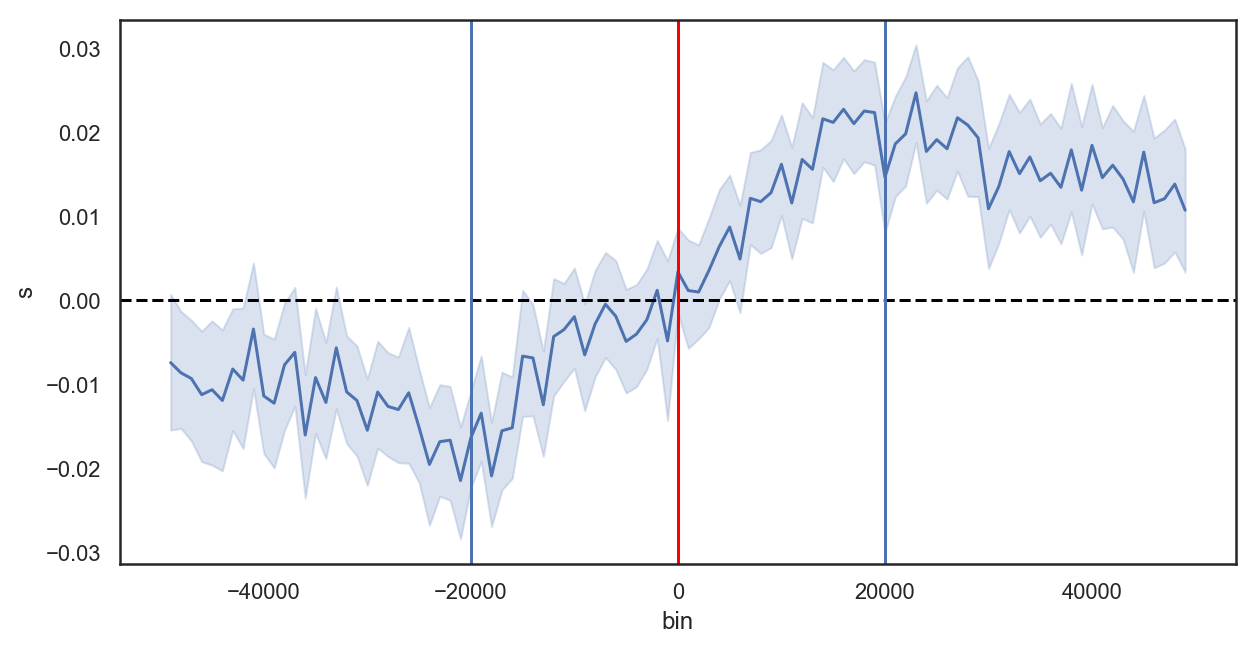

In [23]:
uniform_range = (-20000, 20000)

df = remap_data(skew_data, hotspots.assign(pos=hotspots.pos - np.random.randint(*uniform_range, size=hotspots.pos.size)))

plot_df = df.loc[df.bin.abs() < 50000]

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', data=plot_df, markers=True)
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red')
[plt.axvline(x) for x in uniform_range] ;

So it seems resonable to assume that hotspots are distributed uniformly within ~5000 bp of the center of replication origin.

## Proximity of hotspots to closests CGI, TSS and TES

In [24]:
hotspot_tss_centered = remap_data(hotspots, tss)
hotspot_tes_centered = remap_data(hotspots, tes)
hotspot_cgi_centered = remap_data(hotspots, cgi)

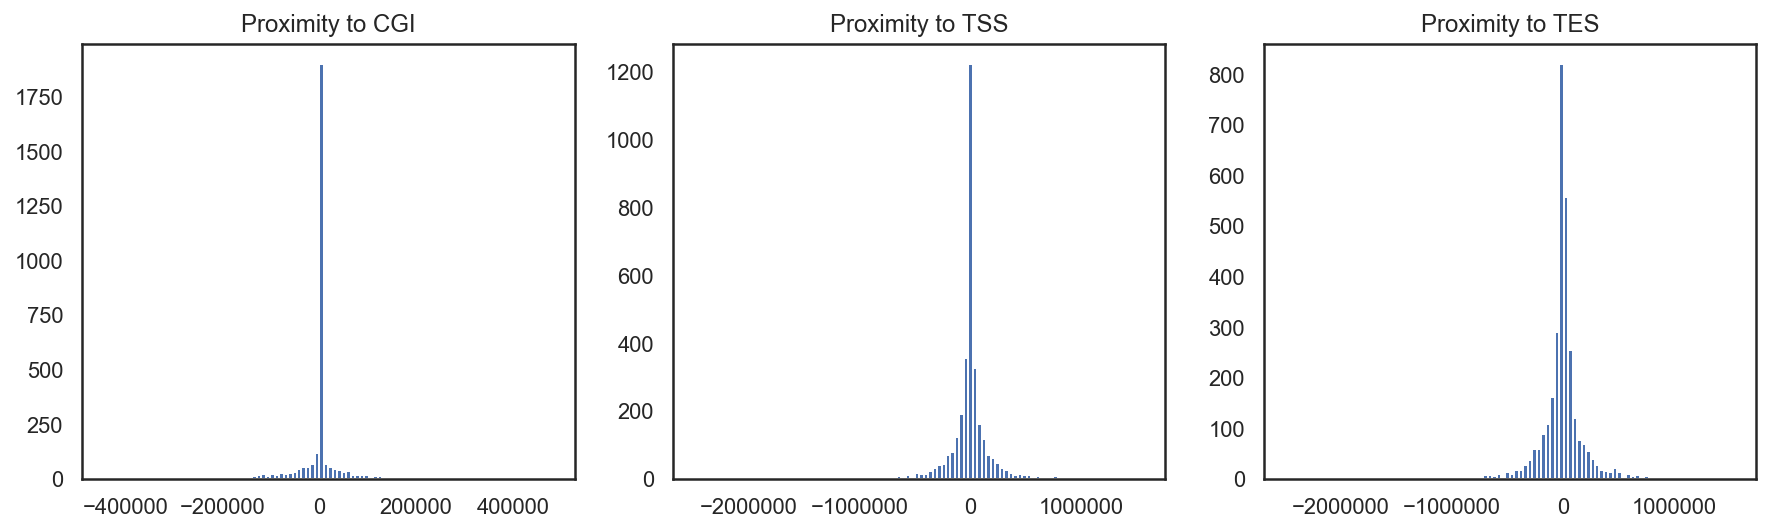

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.hist(hotspot_cgi_centered.pos, bins=100)
ax1.set_title('Proximity to CGI')
ax2.hist(hotspot_tss_centered.pos, bins=100)
ax2.set_title('Proximity to TSS')
ax3.hist(hotspot_tes_centered.pos, bins=100)
ax3.set_title('Proximity to TES') ;

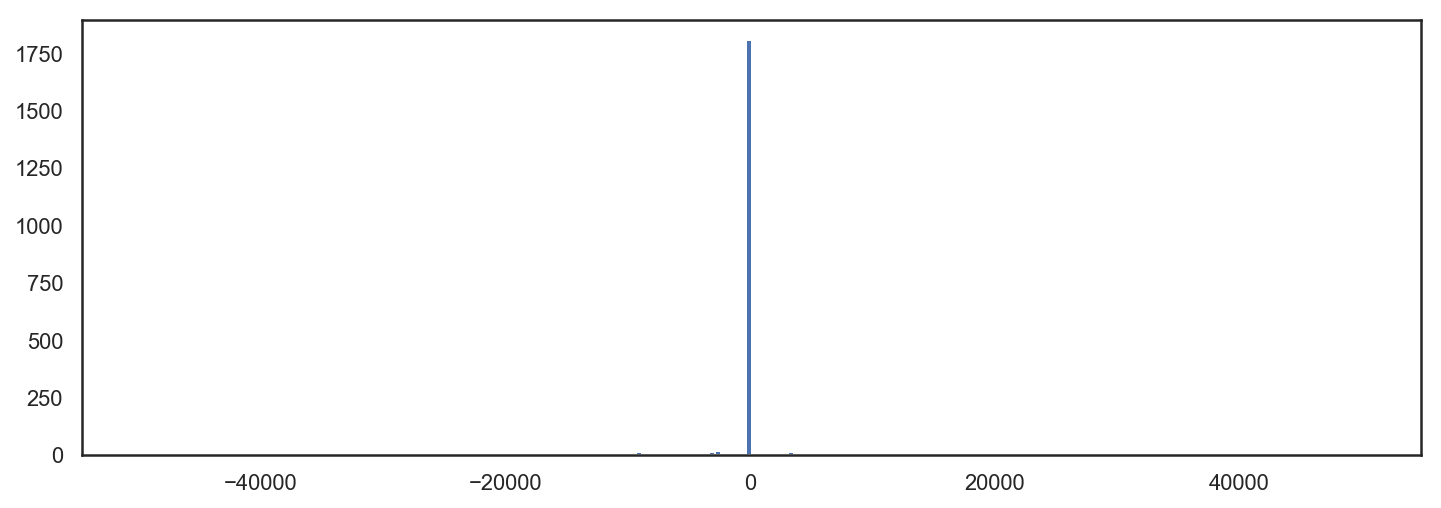

In [26]:
plt.figure(figsize=(12,4))
plt.hist(hotspot_cgi_centered.pos.loc[hotspot_cgi_centered.pos.abs() < 50000], bins=200) ;

It seems hotspots are **on** CGIs, not close to them.

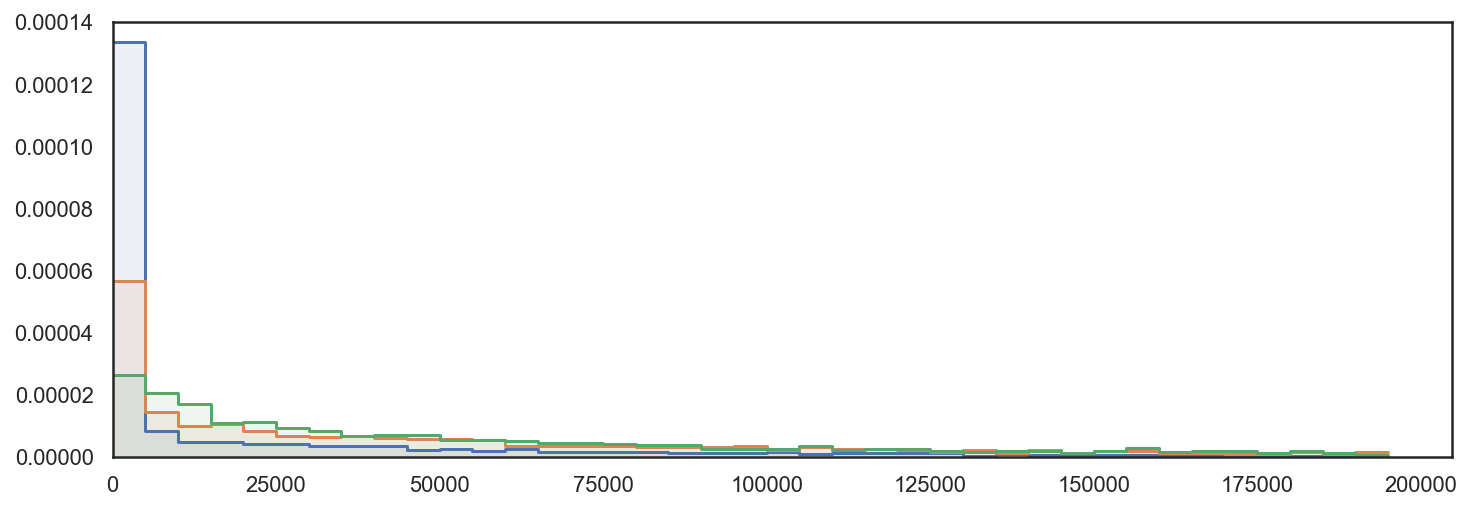

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

hist, bin_edges = np.histogram(hotspot_cgi_centered.pos.abs(), density=True, bins=range(0, 200000, 5000))
df = stairs(pd.DataFrame(dict(start=bin_edges[:-1], end=bin_edges[1:], dens=hist)))
ax.plot(df.pos, df.dens, label='CGI')
ax.fill_between(df.pos, df.dens, alpha=0.1)

hist, bin_edges = np.histogram(hotspot_tss_centered.pos.abs(), density=True, bins=range(0, 200000, 5000))
df = stairs(pd.DataFrame(dict(start=bin_edges[:-1], end=bin_edges[1:], dens=hist)))
ax.plot(df.pos, df.dens, label='TSS')
ax.fill_between(df.pos, df.dens, alpha=0.1)

hist, bin_edges = np.histogram(hotspot_tes_centered.pos.abs(), density=True, bins=range(0, 200000, 5000))
df = stairs(pd.DataFrame(dict(start=bin_edges[:-1], end=bin_edges[1:], dens=hist)))
ax.plot(df.pos, df.dens, label='TES')
ax.fill_between(df.pos, df.dens, alpha=0.1)

plt.ylim(0)
plt.xlim(0) ;

Mean and median distance to CGIs:

In [28]:
hotspot_cgi_centered.pos.abs().mean(), hotspot_cgi_centered.pos.abs().median()

(23685.79589041096, 0.0)

Mean and median distance to TSS:

In [29]:
hotspot_tss_centered.pos.abs().mean(), hotspot_tss_centered.pos.abs().median()

(105228.45541795666, 41502.0)

Mean and median distance to TES:

In [30]:
hotspot_tes_centered.pos.abs().mean(), hotspot_tes_centered.pos.abs().median()

(115822.17599482369, 49792.0)

How many hotspots overlap a CGI?

In [31]:
nr_hotspots_close_to_cgi = len(hotspot_cgi_centered.loc[hotspot_cgi_centered.pos.abs() == 0])
nr_hotspots_close_to_cgi, len(hotspots), nr_hotspots_close_to_cgi / len(hotspots)

(1805, 2856, 0.6320028011204482)

How many hotspots overlap a TSS?

In [32]:
nr_hotspots_close_to_tss = len(hotspot_tss_centered.loc[hotspot_tss_centered.pos.abs() == 0])
nr_hotspots_close_to_tss, len(hotspots), nr_hotspots_close_to_tss / len(hotspots)

(661, 2856, 0.23144257703081234)

Mean and median distance to TSS:

## Significance of proximities

In [33]:
genominterv.proximity_test(hotspots, cgi)

TestResult(statistic=0.5070018115942033, pvalue=0.0)

In [34]:
genominterv.proximity_test(hotspots, tss)

TestResult(statistic=0.5148988095238095, pvalue=0.0)

In [35]:
genominterv.proximity_test(hotspots, tes)

TestResult(statistic=0.49774759284731696, pvalue=0.0)

## Substitution and composition skew around CGI

In [36]:
skew_data_cgi_centered = remap_data(skew_data, cgi)

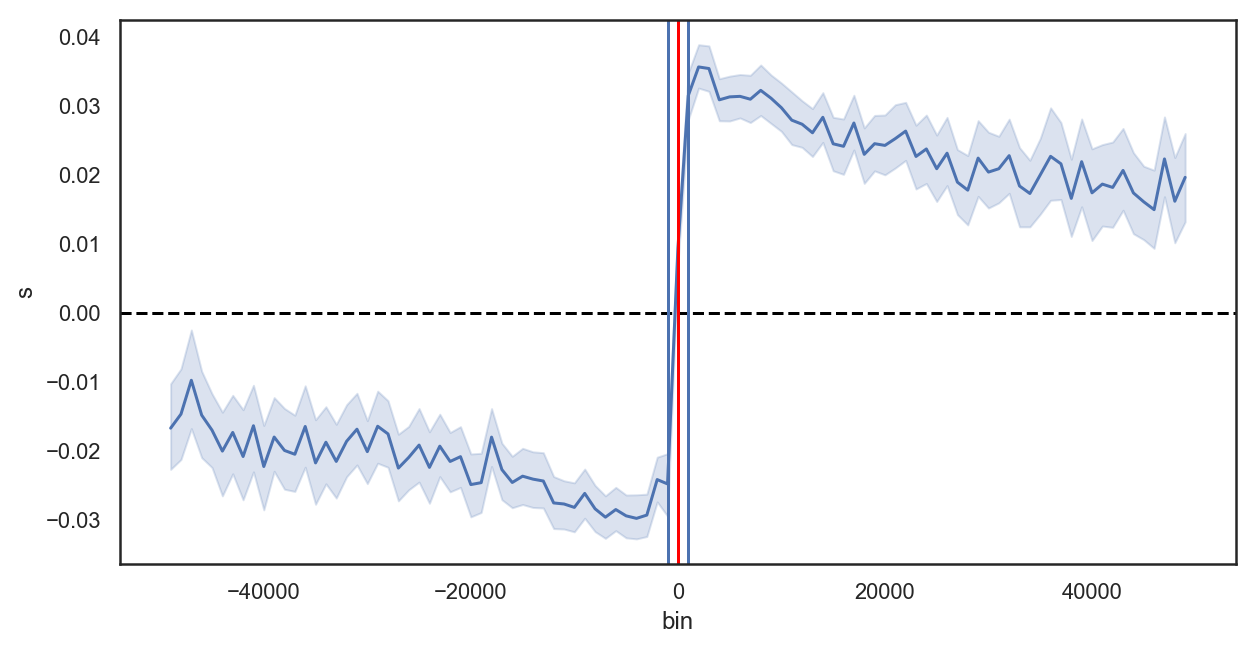

In [37]:
plt.figure(figsize=(10, 5))
plot_df = (skew_data_cgi_centered
           .loc[skew_data_cgi_centered.bin.abs() < 50000]
          )

sns.lineplot('bin', 's', data=plot_df, markers=True)
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red')
plt.axvline(1000)
plt.axvline(-1000) ;

So it seems that origins are exactly at CGIs, even more precicely so than for hotspots. It also seems like the skew persists further from CGIs than from hotspots, but may that is just because there is more data here.

**NB:** Here the center is not pushed to one side, so it seems skew data and genomintrv is fine and that it is the hotspot coordindates that are a bit off.

## Substitution and composition skew around TSS and TES

In [38]:
skew_data_tss_centered = remap_data(skew_data, tss)
skew_data_tss_plus_centered = remap_data(skew_data, tss_plus)
skew_data_tss_minus_centered = remap_data(skew_data, tss_minus)

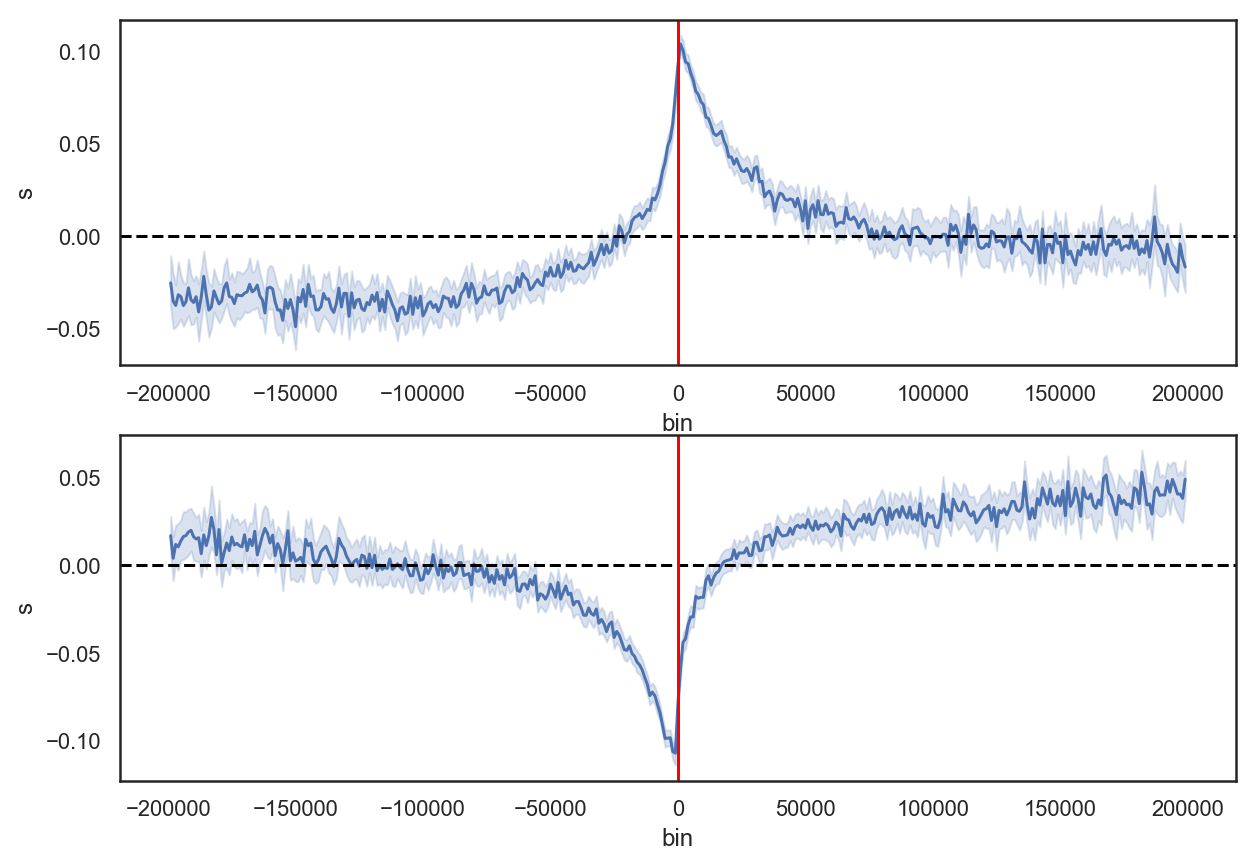

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
plot_df = (skew_data_tss_plus_centered
           .loc[skew_data_tss_plus_centered.bin.abs() < 200000]
          )

sns.lineplot('bin', 's', data=plot_df, markers=True, ax=ax1)
ax1.axhline(0, color='black', linestyle='dashed')
ax1.axvline(0, color='red')

plot_df = (skew_data_tss_minus_centered
           .loc[skew_data_tss_minus_centered.bin.abs() < 200000]
          )

sns.lineplot('bin', 's', data=plot_df, markers=True, ax=ax2)
ax2.axhline(0, color='black', linestyle='dashed')
ax2.axvline(0, color='red') ;

**NB:** This does not make sense...

## Skew around subset of hotspots in introns

In [40]:
#hotspots_in_introns.loc[lambda df: df.start.isnull()]


In [41]:
hotspots_in_introns = genominterv.ovl_interval_data(hotspots, introns)
hotspots_in_introns['pos'] = (hotspots_in_introns.start + \
                              (hotspots_in_introns.end - hotspots_in_introns.start) / 2).round().astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
plot_df = (skew_data_hotspot_centered
           .merge(hotspots_in_introns, 
                  left_on=['chrom', 'prox_start', 'prox_end'],
                  right_on=['chrom', 'pos', 'pos'])
           .loc[lambda df: df.bin.abs() < 50000]
          )

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', data=plot_df, markers=True)
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red') ;

In [ ]:
plot_df = (skew_data_hotspot_centered
           .merge(hotspots_in_introns, 
                  left_on=['chrom', 'prox_start', 'prox_end'],
                  right_on=['chrom', 'pos', 'pos'])
           .loc[lambda df: df.bin.abs() < 50000]
          )
plot_df['bin'] = plot_df.bin * plot_df.strand

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', data=plot_df, markers=True)
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red') ;

It seems that the skew is about the same for all hotspots and for hotspots in introns.

So it does not look like it is the proximity to TSSs that explains the skew... Maybe hotspots are only in the TSS that are also origins? 

## Skew around hotspots at CGIs and far from CGIs

In [ ]:
hotspots_at_cgi = remap_data(cgi, hotspots).loc[lambda df: df.pos.abs() < 5000, 
                                                ['chrom', 'prox_start', 'prox_end']].drop_duplicates()
plot_df = (skew_data_hotspot_centered
           .merge(hotspots_at_cgi, on=['chrom', 'prox_start', 'prox_end'])
           .loc[lambda df: df.bin.abs() < 50000]
          )

# with warnings.catch_warnings(): # ignore FutureWarning
#     warnings.simplefilter("ignore")

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', data=plot_df, markers=True, label='At CGI') ;
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red')

hotspots_far_from_cgi = remap_data(cgi, hotspots).loc[lambda df: df.pos.abs() > 100000, 
                                                ['chrom', 'prox_start', 'prox_end']].drop_duplicates()
plot_df = (skew_data_hotspot_centered
           .merge(hotspots_far_from_cgi, on=['chrom', 'prox_start', 'prox_end'])
           .loc[lambda df: df.bin.abs() < 50000]
          )

sns.lineplot('bin', 's', data=plot_df, markers=True, label='Far away from CGI') ;

So it looks like hotspots show a skew no matter if they are at CGIs or not (all though we cannot rule out that the remaining hotspots are all at undetected CGIs).

## Skew around CGIs at hotspots and far from hotspots

In [ ]:
cgi_at_hotspots = remap_data(hotspots, cgi).loc[lambda df: df.pos.abs() < 5000, 
                                                ['chrom', 'prox_start', 'prox_end']].drop_duplicates()
plot_df = (skew_data_cgi_centered
           .merge(cgi_at_hotspots, on=['chrom', 'prox_start', 'prox_end'])
           .loc[lambda df: df.bin.abs() < 50000]
          )

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', data=plot_df, markers=True, label='At hotspot') ;
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red')

cgi_far_from_hotspots = remap_data(hotspots, cgi).loc[lambda df: df.pos.abs() > 100000, 
                                                ['chrom', 'prox_start', 'prox_end']].drop_duplicates()
plot_df = (skew_data_cgi_centered
           .merge(cgi_far_from_hotspots, on=['chrom', 'prox_start', 'prox_end'])
           .loc[lambda df: df.bin.abs() < 50000]
          )

sns.lineplot('bin', 's', data=plot_df, markers=True, label='Far away from hotspot') ;

## Rank hotspot skews by left half and show right half

In [ ]:
def intgr_left_s_skew(df):
    mask = (df.pos > -50000) &  (df.pos < 0)
    return (np.sign(df.pos.loc[mask]) * df.s.loc[mask]).sum()

values = skew_data_hotspot_centered.groupby(['chrom', 'prox_start', 'prox_end']).apply(intgr_left_s_skew)
plt.hist(values, bins=100) ;

In [ ]:
plot_df = (skew_data_hotspot_centered
           .merge(values.to_frame('intgr_left_s_skew'), 
                  on=['chrom', 'prox_start', 'prox_end'], 
                  how='left')
#            .loc[lambda df: (df.pos >= 0) & (df.pos < 50000)]
           .loc[lambda df: df.pos.abs() < 50000]
          )
print(len(plot_df))
median = plot_df.intgr_left_s_skew.median()
print(median)
plot_df['half'] = [x > median and 'upper' or 'lower' for x in plot_df.intgr_left_s_skew]

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', hue='half',data=plot_df, markers=True)
plt.xlim(-50000, 50000)
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red') ;
ax = plt.gca()
ax.add_patch(Rectangle((-50000, -0.2), 50000, 0.4, facecolor='black', alpha=0.2))

It looks like it is only some of the hotspots that contribute the skew.

## Rank hotspots by AT_skew and show GC_skew

In [ ]:
def intgr_TA_skew(df):
    mask = df.pos.abs() < 5000
    return (np.sign(df.pos.loc[mask]) * df.skew_TA.loc[mask]).sum()

values = skew_data_hotspot_centered.groupby(['chrom', 'prox_start', 'prox_end']).apply(intgr_TA_skew)
plt.hist(values, bins=100) ;

## Other idea: sort by even and show uneven

In [ ]:
plot_df = (skew_data_hotspot_centered
           .merge(values.to_frame('intgr_TA_skew'), 
                  on=['chrom', 'prox_start', 'prox_end'], 
                  how='left')
           .loc[lambda df: df.pos.abs() < 50000]
          )
median = plot_df.intgr_TA_skew.median()
print(median)
plot_df['half'] = [x > median and 'upper' or 'lower' for x in plot_df.intgr_TA_skew]

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 'skew_GC', hue='half', data=plot_df, markers=True)
plt.title('skew_GC') ;
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red') ;

## Rank CGIs by AT_skew and show GC_skew

In [ ]:
values = skew_data_cgi_centered.groupby(['chrom', 'prox_start', 'prox_end']).apply(intgr_TA_skew)
plt.hist(values, bins=100) ;

In [ ]:
plot_df = (skew_data_cgi_centered
           .merge(values.to_frame('intgr_TA_skew'), 
                  on=['chrom', 'prox_start', 'prox_end'], 
                  how='left')
           .loc[lambda df: df.pos.abs() < 50000]
          )
median = plot_df.intgr_TA_skew.median()
plot_df['half'] = [x > median and 'upper' or 'lower' for x in plot_df.intgr_TA_skew]
print(len(plot_df))
plt.figure(figsize=(10, 5))
sns.lineplot('bin', 'skew_GC', hue='half', data=plot_df, markers=True)
plt.title('skew_GC')
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red') ;

It looks like it is only some of the CGIs that contribute the skew.

# is the subset of hotspots with skew overlapping the subset of CGIs with skew. Do the same as above, but split into hotspots overlapping CGIS and hotspots that do not. Do the same for CGIs.

## Permute hotspot positions with sampled distances between hotspots and TSS

In [ ]:
sampled_dist = hotspot_tss_centered.pos.sample(hotspots.pos.size, replace=True).array

df = remap_data(skew_data, hotspots.assign(pos=hotspots.pos + sampled_dist))

plot_df = df.loc[df.bin.abs() < 50000]

plt.figure(figsize=(10, 5))
sns.lineplot('bin', 's', data=plot_df, markers=True)
plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='red')

## Sort hotspots based on their integrated s score

# IT DOES NOT MAKE SENSE THAT PROX START IS ZERO DOES IT?...

## TODO

Do hotspots preferentialy hit CGIs that are origins?


How many hotspots or CGIs *can* be origins, it they are spaced like in mammals and other animals?

Do Jonas predict CpG islands or just GC rich regions?

Is it possible that these regions are produced by gBGC?



So we need to figure out if CGIs only show skew if they are hotspots. We do not have a lot of power to do this becuase we do not have hotspots for the entire genome. This means a CGI may not overlap a hotspot simply because the matching hotspot is not called. Maybe I can get around this by only considerting CGIs close to called hotspots, or by maching each CGI with hotspot with a nearby CGI without hotspot.


Skew is roughly the same at CGIs and hotspots, but only 2/3 of hotspots are at CGIs. See if the overlapping hotspots has different skew than nonoverlapping ones and than non-overlapping CGIs.

Check correlation between AT and GC skew.

Sort and bin (devide by median) hotspots AT_skew and evaluate GC_skew and overlap to CGIs in each bin.

Sort and bin (devide by median) CGIs AT_skew and evaluate GC_skew and overlap to hotspots in each bin.


See if GC* is as high in CGIs as in hotspots

It looks like the pattern for hotspots and CGIs are the same. Check if that means that hotspots not overlapping CGIs do not have skew. Split hostpost into those overlapping CGIs and those that do not (like I did below for TSSs)



- Make sure I do not have a 1000bp bug in genomintrv
- Figure out why skew at hotspts TSS plus and minus look weird (opposite what they should).
- Sort hotspots based on integrated s value and make hotspot subsets with different amout of skew to see if there is a subset with no skew.

- Also try to group by distance from TSS or CpG.

        bins = hotspot_skew_data.closest_orig // 100000 * 100000
        grouped = hotspot_skew_data.groupby(bins)
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for i, x in enumerate(range(0, 300000, 100000)):
            df = grouped.get_group(x)
            print(len(df.prox_start.unique()))
            sns.lineplot('bin', 's', data=df.loc[df.bin.abs() < 50000], ax=axes[i])

- Look at substitution skews.
- Look at how center GC or GC* relates to S skew across region (or maybe just AT_skew that is independent).
- For each species, plot center nX2G+nX2C vs. (nX2G-nX2C)/(nX2G+nX2C) (properly normalized with composition counts) If they do not track each other the relation between replication and hotspots is probably not causal (but just reflects that they often hit the same regions)
- Replicate analysis for the other substitutions skews.
- Split hotspots by annotation and do separate bias plots to see if there is differet bias in hotspots that are not in promoters.
- What does composition and substitution bias profiles look like at the inferred origins?






## Extra:

Color signature plot with phyl distance from zebra finch
